# Detection of Eye Fundus Features

Author: Bohdan Glsievic

This Jupyter notebook serves for PHAS0052 Physics Group Project - Group 1 coding side purposes. We will try to use Python to detect certain features of eye fundus and use image recognition functions to provide quantitative output from medical images.

## Libraries

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import imutils
import pandas as pd
import os
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## Anatomy of the Eye

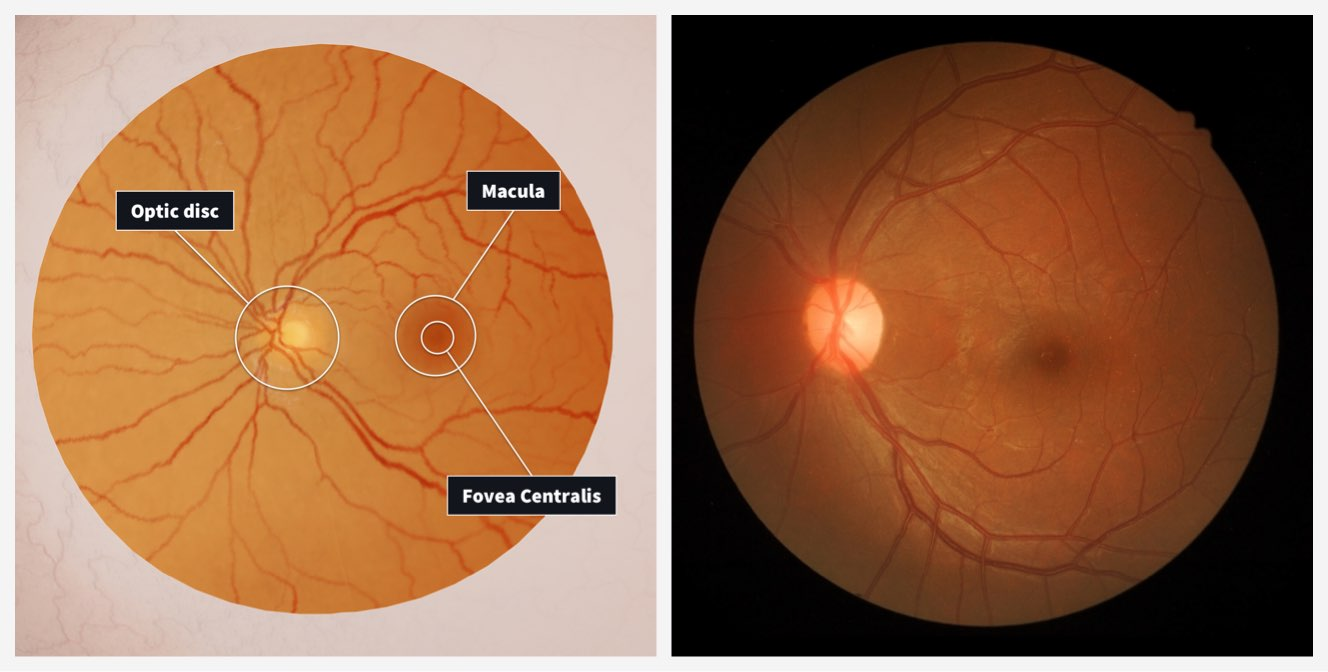

In [11]:
Image('anatomy.jpg', width = 1000)

## 1 | Detection of Optic Disc

The optic disc, also known as the optic nerve head, is the spot on the retina of the eye where the optic nerve enters and exits the eye. The optic nerve carries visual information from the retina to the brain. The optic disc appears as a slightly yellowish or pinkish circular area, typically located towards the nasal side of the retina, and it is often referred to as the "blind spot" because it contains no light-sensitive cells and therefore cannot detect light or form an image. Instead, the brain fills in the visual information from the surrounding areas to create a complete image. The optic disc can be visualized during a comprehensive eye exam and its appearance can provide important information about the health of the optic nerve and the retina.

In this part, we will try to use image recognition methods to detect optical disc. We use open source data set of professional images of the eye fundus taken with a real ophtalmoscope. We decided to first detect optic disc, because it is a very distinct feature of each image and it should not be very difficult to find it precisely.

In majority (or just ideal) cases, optic disc is the brightest spot in the image. However, since eye can slightly move during the capturing processes or undesired reflections can occure (or a patient can have certain disease), its not always easy to find the brightest spot. In our method, we use grayscale images with values between 0 (black) and 255 (white) for each pixel. Afterwards, we apply Guassian blur and filter out all the pixels that have value less than a threshold value. To find the threshold value, we find the maximum value of the pixel in the image (actually only in the circular part of the image because we wanted to omit pixel too close to the edges of the ophatlmoscope as this was the place with the most likely occurence of undesired reflections). Then we apply linear regression to find the threshold value based on the maximum pixel value in the image. After tht, we find the contours. There might be many contour. Thats why we first filter out those that have small area (most likely just noise) and then find the contoru that is closest to the centre of the eye fundus. We work under the assumption that optic disc will be relatively close to the centre although its not the case for all images. 

In the cell below, we define image recognition functions.

In [12]:
def Resize(image, factor = 0.5):
    '''
    This function changes dimensions of the image. The original images have high resolution and 
    OpenCV opens images in 1-1 resolution with the display. Therefore, by default, this function
    reduces size of the image to 25% (factor^2 * 100) of the original size
    Inputs:
        image  - image array
        factor - resize factor
    Outputs:
        image  - resized image
    Assumptions:
        - OpenCV was called
    '''
    dim   = (int(image.shape[1] * factor), int(image.shape[0] * factor))
    image = cv2.resize(image, dim)
    return image

def SquareCrop(image):
    '''
    This function crops image into a square of maximum area. Both sides are cropped to the length 
    of the shorter original side and crop is centred.
    Inputs:
        image - image array
    Outputs:
        image - cropped image
    Assumptions:
        - OpenCV was called
        - NumPy was called
    '''
    x , y = np.shape(image)[1], np.shape(image)[0]
    image = image[:,int(abs(x-y)/2):x-int(abs(x-y)/2)]
    return image

def CircleCrop(image):
    '''
    This function crops image into a circle of maximum area. The radius is determined by the function
    and the crop is centred.
    Inputs:
        image         - image array
    Outputs:
        cropped_image - cropped image
    Assumptions:
        - OpenCV was called
    '''
    radius = int(np.round(image.shape[0] / 2 * 0.87))
    
    # Set the center of the circle
    center = (image.shape[1] // 2, image.shape[0] // 2)
    
    # Create a mask with a white circle on a black background
    mask = np.zeros_like(image)
    cv2.circle(mask, center, radius, (255, 255, 255), -1)
    
    # Apply the mask to the original image
    masked_image = cv2.bitwise_and(image, mask)
    
    # Crop the masked image to the circle shape
    x, y, w, h = cv2.boundingRect(mask)
    cropped_image = masked_image[y:y+h, x:x+w]
    return cropped_image

def CutOff(image):
    '''
    This function finds the threshold (cutoff) pixel value. We first try to find the maximum pixel
    value in the enclosed circle of the image (as the top boundary) and then we caluclate the value
    below which all pixel will definitely not belong to the optic disc as their brightness is too
    low.
    Inputs:
        image - image array
    Outputs:
        value - value of the brightness threshold
    Assumptions:
        - NumPy was called
        - function CircleCrop exists
    '''
    value = 0.85 * np.max(CircleCrop(image))
    return value

def ClosestContour(contours, image):
    '''
    This function finds the contour closest to the centre of the eye fundus. We defined this function
    because pure brightness threshold method does not alway perfectly filter out all bright spots. 
    This function was created with the assumption that the optic disc will be closest to the centre 
    of the eye fundus.
    Inputs:
        contours - contours of the image
    Outputs:
        arg - index of the contour closest to the centre
    Assumptions:
        - NumPy was called
        - OpenCV was called
    '''
    R = []
    
    for c in contours:
        center = (image.shape[1] // 2, image.shape[0] // 2)             # centre of the image
    
        x,y,w,h = cv2.boundingRect(c)                                   # bound contour in a rectangle
    
        cx = x + (w/2)                                                  # centre of the contour in x
        cy = y + (h/2)                                                  # centre of the contour in y
    
        r = np.sqrt((center[1] - cx)**2 + (center[0] - cy)**2)          # calcualte the distance from the centre
        R.append(r)
    
    arg = np.argmin(np.array(R))                                        # find the contoru closes to the centre
    return arg

def AreaContoruFilter(contours, image):
    '''
    Filter out the contours that have small area (are most likely noise).
    Inputs:
        contours - contours of the image
        image    - array of the image
    Outputs:
        contours - contours of the image that have area bigger than the threshold value
    Assumptions:
        - OpenCV was called
    '''
    min_area = int(np.round(0.0003945 * image.shape[0]**2))
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    return contours

In [13]:
def find_OpticDisc(image_path, display = False, use_CV = False):
    '''
    This function finds an optic disc in the image of eye retina.
    Inputs:
        image_path - directory of the images                        [string]
        display    - display the image with detected optic disc     [Boolean]
        use_CV     - display the image using OpenCV                 [Boolean]
    Outpus:
        cx         - x coordinate of centre of mass                 [integer]
        cy         - y coordinate of centre of mass                 [integer]
    Assumption:
        - NumPy library was called
        - Matplotlib library was called
        - OpenCV library was called
        - Resize function exists
        - CutOff function exists
        - AreaContoruFilter function exists
        - ClosestContour function exists
    '''
    image_original = Resize(cv2.imread(image_path))                             # load the original image and resize
    image_gray     = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)               # load the original image in gray-scale
    
    ## Change Dimensions of the Image ##
    image = Resize(image_gray)                                                  # resize the image

    ## Find Threshold Image ##
    thresh      = np.where(cv2.GaussianBlur(image,(25,25),0) < CutOff(image), 0, cv2.GaussianBlur(image,(25,25),0))
    thresh_crop = thresh

    ## Contours ##

    contours = cv2.findContours(thresh_crop, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)        # find contours in the image
    contours = imutils.grab_contours(contours)                                              # assemble contours

    contours = AreaContoruFilter(contours, image_original)                                  # filter contours by area


    c = contours[ClosestContour(contours, thresh)]               # find the contour closest to the centre
    x,y,w,h = cv2.boundingRect(c)
    x,y,w,h = cv2.boundingRect(c)                                # max values of the contour
    cx = x + (w/2)                                               # X-coord of blue track point
    cy = y + (h/2)                                               # Y-coord of blue track point

    cv2.circle(image_original, (int(cx), int(cy)), int(np.round(image_original.shape[0] * 0.0702)),(255,0,0), 2)      # create a circle for center of mass
    
    ## Display the Image ##
    if display == True:
        if use_CV == True:                                       # display using OpenCV
            cv2.imshow('image (orginal)', image_original)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        else:                                                    # display using Matplotlib
            plt.figure()
            plt.imshow(image_original)
            plt.axis('off')
            plt.show()

    return cx, cy

**Find optic disc using computer**

In [14]:
path_test = 'Test_Set/Test/'                                    # path of the images data set

coordinates_COMP = []                                           # empty list for coordinates of optic disc (computer)
skip_images      = []                                           # empty list for images that need to be skipped

for image_number in range(1,301):
    image_path     = path_test + f'{image_number}.png'                         # define the image path
    try:
        # Do something with the current number
        cx, cy = find_OpticDisc(image_path)                                    # find coordinates of optic disc
    except:
        # If an error occurs, add the current number to the skip_nums list
        skip_images.append(image_number)                                       # append images that need to be skipped
        print(f"Encountered an error on iteration {image_number}. Skipping this number.")

for image_number in range(1,301):
    if image_number in skip_images:                                        # skip image from skip_images array
        image_number += 1
    image_path     = path_test + f'{image_number}.png'                     # define the image path
    print(image_number)
    cx, cy = find_OpticDisc(image_path)
    coordinates_COMP.append([image_number, cx, cy])                        # add positions to coordiantes found by computer

**Find optic disc using human evaluation**

In [135]:
def sort_by_number(filename):
    '''
    Sorts the images by number.
    Inputs:
        filename - name of the file [string]
    '''
    return int(filename[:-4])

image_files = os.listdir(path_test)                 # load images file from the folder
image_files.sort(key = sort_by_number)              # sort the image from the folder by number

coordinates_human = []                              # empty list for coordinates of optic disc chosen by human

n = 500                                             # number of images to analyse
i = 0

for image_file in image_files[:n]:
    image_path = os.path.join(path_test, image_file)            # image path
    image = cv2.imread(image_path)                              # load the image
    image = Resize(image)                                       # resize the image
    
    cv2.imshow('image', image)                                  # show the image

    
    def get_coordinates(event, x, y, flags, param):
        '''
        Obtains the coordiantes from the image by clicking.
        '''
        if event == cv2.EVENT_LBUTTONDOWN:                      # left-click button condition
            coordinates_human.append([i, x, y])                 # add coordinates of optic disc to the array
            print(f'Clicked at ({i}, {x}, {y})')
            cv2.destroyAllWindows()

    cv2.setMouseCallback('image', get_coordinates)              # mouse click function
    
    # Wait for a mouse click or key press
    key = cv2.waitKey(0)

    # Check if the 'x' key was pressed
    if key == ord('x'):
        cv2.destroyAllWindows()
        break
    i += 1
    
    
    
# Convert the coordinates array to a numpy array
coordinates_human = np.array(coordinates_human)
coordinates_human = coordinates_human.astype(int)

Clicked at (0, 790, 389)
Clicked at (1, 271, 338)
Clicked at (2, 568, 384)
Clicked at (3, 534, 356)
Clicked at (4, 267, 313)
Clicked at (5, 874, 335)
Clicked at (6, 258, 370)
Clicked at (7, 800, 328)
Clicked at (8, 501, 372)
Clicked at (9, 816, 338)
Clicked at (10, 258, 331)
Clicked at (11, 259, 325)
Clicked at (12, 269, 337)
Clicked at (13, 813, 345)
Clicked at (14, 794, 335)
Clicked at (15, 282, 293)
Clicked at (16, 283, 353)
Clicked at (17, 548, 365)
Clicked at (18, 514, 351)
Clicked at (19, 264, 322)
Clicked at (20, 843, 333)
Clicked at (21, 813, 329)
Clicked at (22, 826, 506)
Clicked at (23, 271, 384)
Clicked at (24, 256, 347)
Clicked at (25, 234, 321)
Clicked at (26, 289, 330)
Clicked at (27, 258, 360)
Clicked at (28, 248, 403)
Clicked at (29, 485, 320)
Clicked at (30, 773, 361)
Clicked at (31, 570, 364)
Clicked at (32, 542, 373)
Clicked at (33, 301, 384)
Clicked at (34, 278, 375)
Clicked at (35, 788, 348)
Clicked at (36, 799, 288)
Clicked at (37, 252, 432)
Clicked at (38, 234, 3

Clicked at (308, 238, 366)
Clicked at (309, 783, 409)
Clicked at (310, 772, 296)
Clicked at (311, 281, 378)
Clicked at (312, 273, 349)
Clicked at (313, 803, 331)
Clicked at (314, 284, 316)
Clicked at (315, 789, 346)
Clicked at (316, 318, 312)
Clicked at (317, 788, 357)
Clicked at (318, 824, 412)
Clicked at (319, 287, 327)
Clicked at (320, 272, 320)
Clicked at (321, 800, 357)
Clicked at (322, 806, 388)
Clicked at (323, 259, 331)
Clicked at (324, 830, 345)
Clicked at (325, 808, 362)
Clicked at (326, 801, 391)
Clicked at (327, 280, 400)
Clicked at (328, 782, 314)
Clicked at (329, 802, 344)
Clicked at (330, 800, 324)
Clicked at (331, 286, 367)
Clicked at (332, 262, 325)


**Load coordinates from the file**

In [5]:
coordinates_HUMAN = np.loadtxt('coordinates_HUMAN.txt')
mask = np.logical_not(np.isin(np.arange(coordinates_HUMAN.shape[0]), np.array(skip_images) - 1))
coordinates_HUMAN = coordinates_HUMAN[mask, :]
x1, y1 = coordinates_HUMAN[:,1], coordinates_HUMAN[:,2]

coordinates_COMP = np.loadtxt('coordinates_COMP.txt')
mask = np.logical_not(np.isin(np.arange(coordinates_COMP.shape[0]), np.array(skip_images) - 1))
coordinates_COMP = coordinates_COMP[mask, :]
x2, y2 = coordinates_COMP[:,1], coordinates_COMP[:,2]

In [ ]:
Errors = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

distances = np.arange(0,200,5)
success   = np.zeros(len(distances))

for i in range(len(distances)):
    success[i] = 100 * np.count_nonzero(Errors < distances[i]) / len(Errors)

<IPython.core.display.Javascript object>


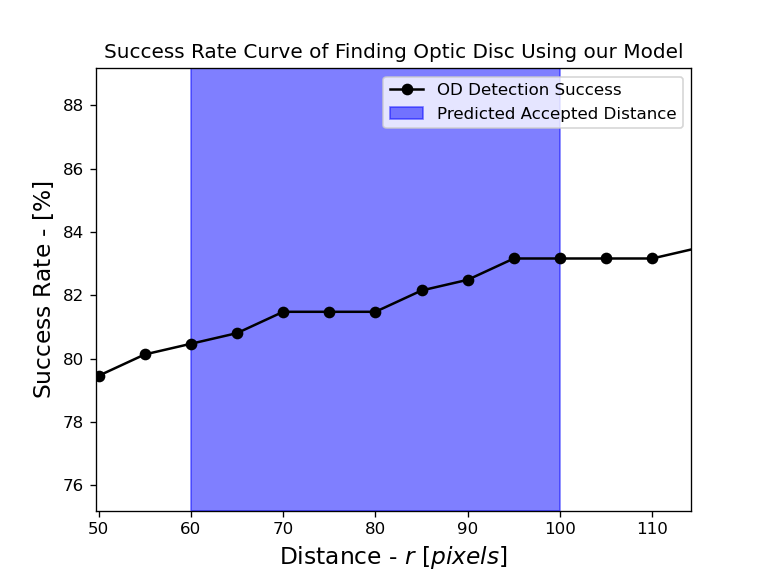

In [35]:
fig, ax = plt.subplots()

ax.plot(distances, success, 'o-', color = 'black', label = 'OD Detection Success', zorder = 2)

ax.axvspan(60, 100, alpha = 0.5, color = 'blue', label = 'Predicted Accepted Distance', zorder = 1)

ax.set_xlabel(r'Distance - $r$ $[pixels]$', fontsize = 14)
ax.set_ylabel(r'Success Rate - $[\%]$', fontsize = 14)
ax.set_title(r'Success Rate Curve of Finding Optic Disc Using our Model')

plt.legend()

#plt.savefig('success.png', dpi = 1000, transparent = True)

plt.show()

<IPython.core.display.Javascript object>


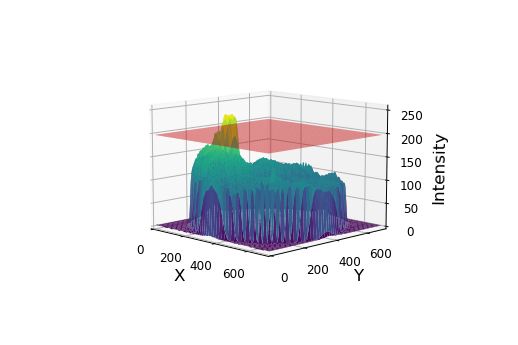

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for x, y, and z coordinates
x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
z = image

# Create colormap and normalize data
#cmap = plt.cm.gray
norm = plt.Normalize(vmin=z.min(), vmax=z.max())

# Plot 3D surface
surf = ax.plot_surface(x, y, z, cmap='viridis', norm=norm)

z_plane = CutOff(image) * np.ones(image.shape)   # constant z value of plane
x_plane, y_plane = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
c_plane = np.ones_like(z_plane) * 255  # constant color value (red)

plane = ax.plot_surface(x_plane, y_plane, z_plane, alpha=0.5, color='r')

# Set axis labels and limits
ax.set_xlabel('X', fontsize = 14)
ax.set_ylabel('Y', fontsize = 14)
ax.set_zlabel('Intensity', fontsize = 14)
ax.set_xlim([0, image.shape[1]])
ax.set_ylim([0, image.shape[0]])
ax.set_zlim([0, 255])

ax.view_init(10, 315)

# Add colorbar
#fig.colorbar(surf, shrink=0.5, aspect=5)

# plt.savefig('CutOff.png', dpi = 1000, transparent = True)

# Show plot
plt.show()